# Automated Dataset Annotation with GroundingDINO and Segment Anything Model

## Install Grounding DINO and Segment Anything Model

Our project will use two groundbreaking designs:
- [Grounding DINO](https://arxiv.org/abs/2303.05499) for zero-shot object detection
- [Segment Anything Model (SAM)](https://segment-anything.com/) for converting bounding boxes into segmentations. 


In [ ]:
# To make it easier for us to manage datasets, images and models, we create a HOME constant.
import os
HOME = os.getcwd()
print("HOME:", HOME)

In [ ]:
# Clone the GroundingDINO repository
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO

# Install the necessary dependencies
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

In [ ]:
# Install SAM
%cd {HOME}
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [ ]:
# Install necessary packages
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

!pip install -q roboflow

from IPython.display import Image, clear_output
clear_output()

### Download Grounding DINO Model Weights

To run Grounding DINO we need two files - configuration and model weights. The configuration file is part of the [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) repository, which we have already cloned. The weights file, on the other hand, we need to download. We write the paths to both files to the `GROUNDING_DINO_CONFIG_PATH` and `GROUNDING_DINO_CHECKPOINT_PATH` variables and verify if the paths are correct and the files exist on disk.

In [ ]:
import os

# Define the path to the GroundingDINO config file
GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

In [ ]:
import os

# Define the path to the GroundingDINO checkpoint
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

### Download Segment Anything Model (SAM) Weights

As with Grounding DINO, in order to run SAM we need a weights file, which we must first download. We write the path to local weight file to `SAM_CHECKPOINT_PATH` variable and verify if the path is correct and the file exist on disk.

In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
import os

# Define the path to the SAM checkpoint
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

## Load models

In [ ]:
import torch

# Check if CUDA is available and set the device accordingly
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Grounding DINO Model

In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

### Load Segment Anything Model (SAM)

In [ ]:
from segment_anything import sam_model_registry, SamPredictor

SAM_ENCODER_VERSION = "vit_h"
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

## Download Example Data

In [ ]:
# All images are stored in data/
f"{HOME}/data"
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

In [ ]:
# Install the Kaggle API
!pip install kaggle

from google.colab import files
files.upload()

clear_output()

In [ ]:
# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # Read and write permissions

clear_output()

In [ ]:
# Download the dataset
!kaggle datasets download -d mostafaabla/garbage-classification

# Unzip the dataset
!unzip garbage-classification.zip

clear_output()

In [ ]:
# 12 classes of images (garbages)
!ls "/content/data/garbage_classification/"

battery     brown-glass  clothes      metal  plastic  trash
biological  cardboard	 green-glass  paper  shoes    white-glass


## Single Image Mask Auto Annotation

Before we automatically annotate the entire dataset let's focus for a moment on a single image.

In [ ]:
SOURCE_IMAGE_PATH = f"{HOME}/data/garbage_classification/green-glass/green-glass446.jpg"
CLASSES = ['green-glass']
BOX_TRESHOLD = 0.40
TEXT_TRESHOLD = 0.25

### Zero-Shot Object Detection with Grounding DINO

**NOTE:** To get better Grounding DINO detection we will leveragae prompt engineering using `enhance_class_name` function defined below. 

Source: [Grounding DINO tutorial](https://blog.roboflow.com/grounding-dino-zero-shot-object-detection/).

In [ ]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    """
    Enhances class names by appending 's' and prepending 'all' to each class name.
    
    Args:
        class_names (List[str]): List of class names
    
    Returns:
        List[str]: Enhanced class names
    
    """
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

In [ ]:
import cv2
import supervision as sv

# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# get the index of the 'green-glass' class
green_glass_id = CLASSES.index('green-glass')
print(green_glass_id)

# FORCE into xx class
print(detections.class_id)
print(detections)

new_class_ids = []
for cid in detections.class_id:
    # assign the 'green-glass' class index if class_id is None
    if cid is None:
        new_class_id = green_glass_id
    else:
      new_class_id = cid
    new_class_ids.append(new_class_id)

# Assign the new class IDs to detections.class_id
detections.class_id = new_class_ids

print(detections.class_id)
print(detections)

# annotate image with detections
box_annotator = sv.BoxAnnotator()

labels = [
    f"{CLASSES[class_id if class_id is not None else green_glass_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections
]

annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Plot the annotated image
%matplotlib inline
sv.plot_image(annotated_frame, (10, 10))

### Prompting SAM with detected boxes

In [ ]:
import numpy as np
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    """
    Segment objects in the image based on bounding boxes using the given SamPredictor.

    Args:
        sam_predictor (SamPredictor): SamPredictor instance for segmentation
        image (np.ndarray): Input image for segmentation
        xyxy (np.ndarray): Bounding boxes in the format [x1, y1, x2, y2]

    Returns:
        np.ndarray: Array of segmented masks

    """
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores) # Get the index of the highest score
        result_masks.append(masks[index]) # Append the segmented mask with the highest score
    return np.array(result_masks) # Return the segmented masks as an array

In [ ]:
import cv2

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB), # Convert the image to RGB color space
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

green_glass_id = CLASSES.index('green-glass')
labels = [
    f"{CLASSES[class_id if class_id is not None else green_glass_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections
]

# Annotate the image with masks
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

# Annotate the image with bounding boxes and labels
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

# Plot the annotated image
%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

## Full Dataset Mask Auto Annotation

In [ ]:
import os

IMAGES_EXTENSIONS = ['jpg', 'jpeg', 'png']

IMAGES_DIRECTORY = os.path.join(HOME, 'data/garbage_classification/clothes')
CLASSES = ['clothes']
BOX_TRESHOLD = 0.40
TEXT_TRESHOLD = 0.25

IMAGES_DIRECTORY

### Extract labels from images

In [ ]:
import cv2
from tqdm.notebook import tqdm
import random

images = {}
annotations = {}

image_paths = sv.list_files_with_extensions(
    directory=IMAGES_DIRECTORY, 
    extensions=IMAGES_EXTENSIONS)


# Randomly down-sample 1000 image paths
image_paths_sample = random.sample(image_paths, 1000) # Toggle this!

green_glass_id = CLASSES.index('clothes') # Toggle this!

for image_path in tqdm(image_paths_sample):
    image_name = image_path.name
    image_path = str(image_path)
    image = cv2.imread(image_path)

    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    
    # Replace all the None in class_id!!!
    new_class_ids = []
    for cid in detections.class_id:
        if cid is None:
            new_class_id = green_glass_id # Toggle this!
        else:
          new_class_id = cid
        new_class_ids.append(new_class_id)
    detections.class_id = new_class_ids
    # Replace all the None in class_id!!!

    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )
    
    images[image_name] = image
    annotations[image_name] = detections

### Save labels in Pascal VOC XML

Before uploading our annotations to Roboflow, we must first save them to our hard drive. To do this, we will use one of the latest `supervision` features (available with the `0.6.0` update 🔥) - [dataset save](https://roboflow.github.io/supervision/dataset/core/).

In [ ]:
ANNOTATIONS_DIRECTORY = os.path.join(HOME, 'annotations/clothes')

MIN_IMAGE_AREA_PERCENTAGE = 0.002
MAX_IMAGE_AREA_PERCENTAGE = 0.80
APPROXIMATION_PERCENTAGE = 0.75

In [ ]:
sv.Dataset(
    classes=CLASSES,
    images=images,
    annotations=annotations
).as_pascal_voc(
    annotations_directory_path=ANNOTATIONS_DIRECTORY,
    min_image_area_percentage=MIN_IMAGE_AREA_PERCENTAGE,
    max_image_area_percentage=MAX_IMAGE_AREA_PERCENTAGE,
    approximation_percentage=APPROXIMATION_PERCENTAGE
)

Save permanently to my Drive!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Upload annotations to Roboflow

Now we are ready to upload our annotations to Roboflow using the API.

In [ ]:
PROJECT_NAME = "auto-generated-dataset-CSE493-clothes"
PROJECT_DESCRIPTION = "auto-generated-dataset-CSE493-clothes"

In [ ]:
import roboflow
from roboflow import Roboflow

roboflow.login()

workspace = Roboflow().workspace()
new_project = workspace.create_project(
    project_name=PROJECT_NAME,
    project_license="MIT",
    project_type="instance-segmentation", 
    annotation=PROJECT_DESCRIPTION)

In [ ]:
import os

# Iterate over the sampled image paths
for image_path in tqdm(image_paths_sample):
    image_name = image_path.name
    annotation_name = f"{image_path.stem}.xml"
    image_path = str(image_path)
    annotation_path = os.path.join(ANNOTATIONS_DIRECTORY, annotation_name)

    # Upload the image and annotation to the new project
    new_project.upload(
        image_path=image_path, 
        annotation_path=annotation_path, 
        split="train", 
        is_prediction=True, 
        overwrite=True, 
        tag_names=["auto-annotated-with-grounded-sam"],
        batch_name="auto-annotated-with-grounded-sam"
    )

### Download Object Detection Dataset from Roboflow

To use the dataset in this tutorial make sure to download it in [Pascal VOC XML](https://roboflow.com/formats/pascal-voc-xml) format. We will use [BlueBerries dataset](https://universe.roboflow.com/inkyu-sa-e0c78/blueberries-u0e84) as example.

In [ ]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("inkyu-sa-e0c78").project("blueberries-u0e84")
dataset = project.version(1).download("voc")

/content
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to BlueBerries-1 in voc:: 100%|██████████| 161/161 [00:00<00:00, 1752.68it/s]


In [ ]:
dataset.location

'/content/BlueBerries-1'

In [ ]:
!ls {dataset.location}

README.dataset.txt  README.roboflow.txt  test  train  valid


### Load and Visualize Object Detection Dataset with Supervision

Learn more about Supervision Dataset support from our [documentation](https://roboflow.github.io/supervision/dataset/core/).

In [ ]:
object_detection_dataset = sv.Dataset.from_pascal_voc(
    images_directory_path=f"{dataset.location}/train",
    annotations_directory_path=f"{dataset.location}/train"
)

In [ ]:
import random
random.seed(9001)

**NOTE:** Rerun the cell below 👇 to take a look at different image from the dataset.

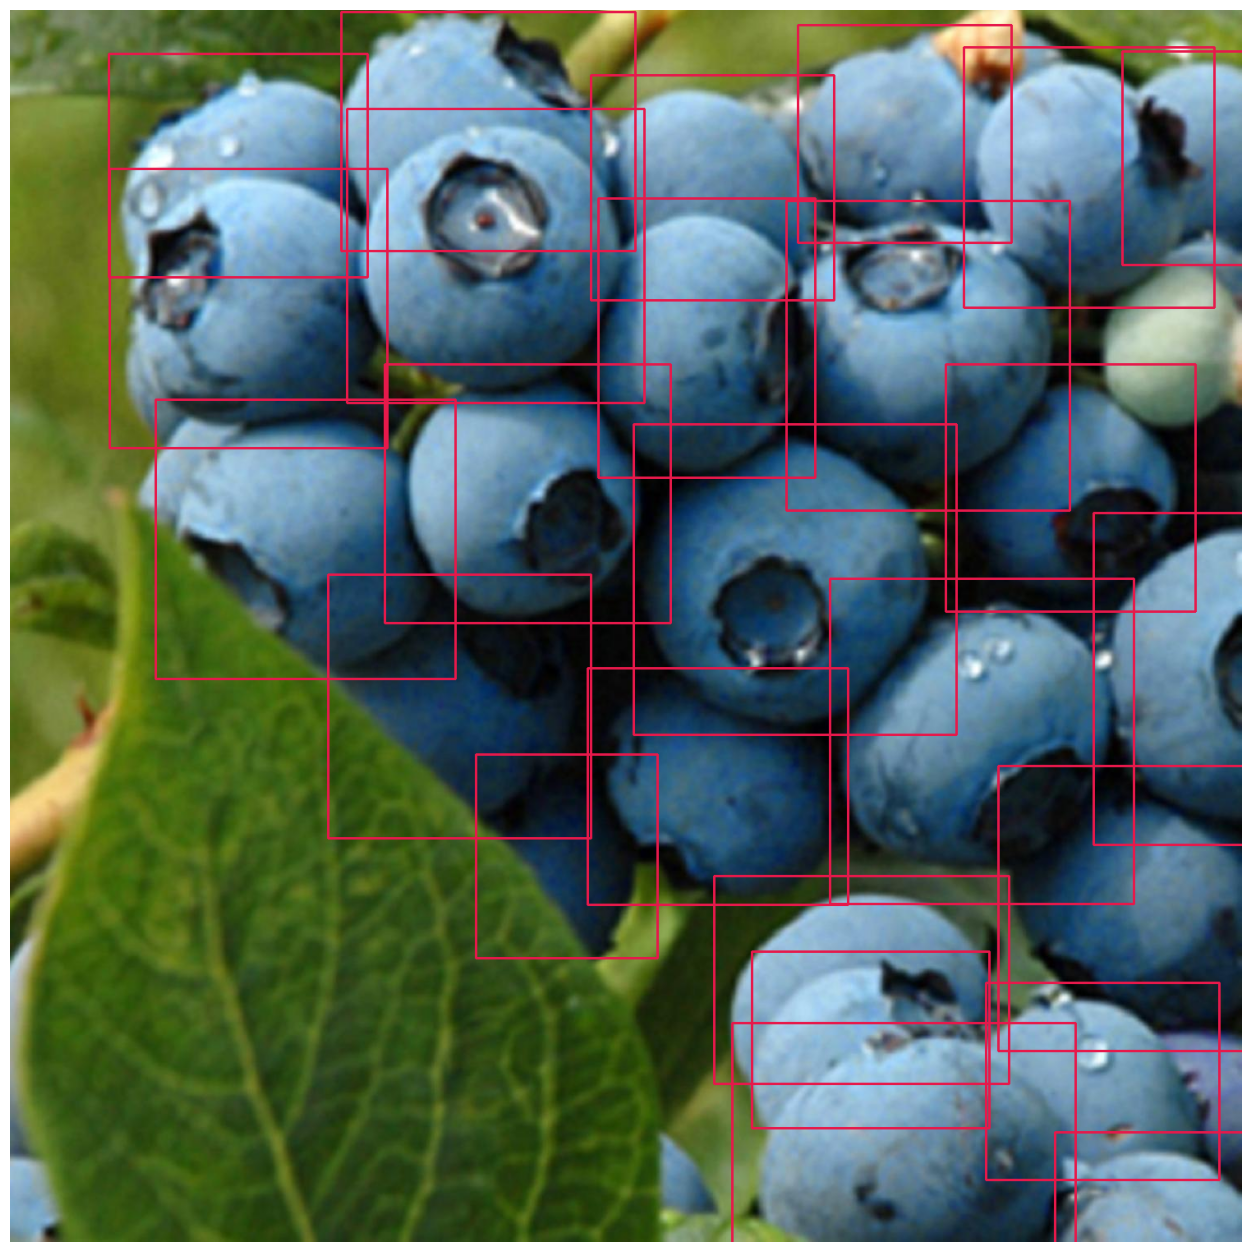

In [ ]:
image_names = list(object_detection_dataset.images.keys())
image_name = random.choice(image_names)

image = object_detection_dataset.images[image_name]
detections = object_detection_dataset.annotations[image_name]

box_annotator = sv.BoxAnnotator()

annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections, skip_label=True)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

### Run SAM convert Boxes into Masks

In [ ]:
from tqdm.notebook import tqdm

for image_name, image in tqdm(object_detection_dataset.images.items()):
    detections = object_detection_dataset.annotations[image_name]
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

  0%|          | 0/63 [00:00<?, ?it/s]

**NOTE:** Rerun the cell below 👇 to take a look at different image from converted dataset.

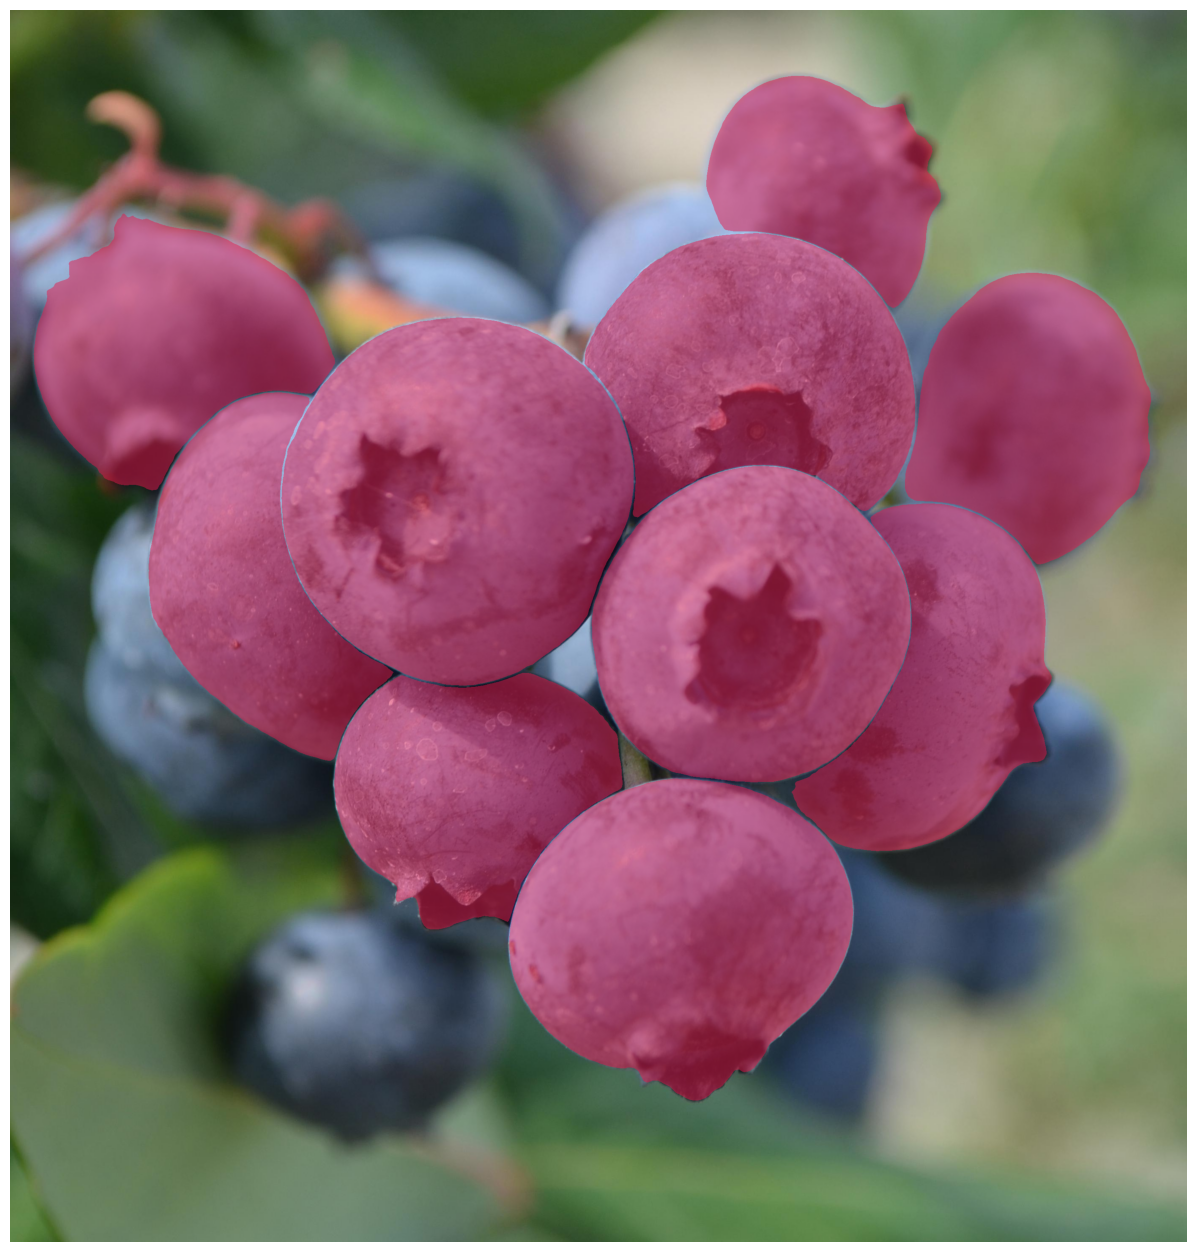

In [ ]:
image_names = list(object_detection_dataset.images.keys())
image_name = random.choice(image_names)

image = object_detection_dataset.images[image_name]
detections = object_detection_dataset.annotations[image_name]

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

### Save labels in Pascal VOC XML

Before uploading our annotations to Roboflow, we must first save them to our hard drive. To do this, we will use one of the latest `supervision` features (available with the `0.6.0` update 🔥) - [dataset save](https://roboflow.github.io/supervision/dataset/core/).

In [ ]:
ANNOTATIONS_DIRECTORY = os.path.join(dataset.location, 'annotations')

MIN_IMAGE_AREA_PERCENTAGE = 0.002
MAX_IMAGE_AREA_PERCENTAGE = 0.80
APPROXIMATION_PERCENTAGE = 0.75

In [ ]:
object_detection_dataset.as_pascal_voc(
    annotations_directory_path=ANNOTATIONS_DIRECTORY,
    min_image_area_percentage=MIN_IMAGE_AREA_PERCENTAGE,
    max_image_area_percentage=MAX_IMAGE_AREA_PERCENTAGE,
    approximation_percentage=APPROXIMATION_PERCENTAGE
)

### Upload annotations to Roboflow

Now we are ready to upload our annotations to Roboflow using the API.

In [ ]:
import roboflow
from roboflow import Roboflow

roboflow.login()

workspace = Roboflow().workspace()
new_project = workspace.create_project(
    project_name=dataset.name,
    project_license="MIT",
    project_type="instance-segmentation", 
    annotation=f"{dataset.name}-boxes-to-segmentations")

You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


In [ ]:
import os

image_paths = sv.list_files_with_extensions(directory=f"{dataset.location}/train", extensions=["jpg", "jpeg", "png"])
for image_path in tqdm(image_paths):
    image_name = image_path.name
    annotation_name = f"{image_path.stem}.xml"
    image_path = str(image_path)
    annotation_path = os.path.join(ANNOTATIONS_DIRECTORY, annotation_name)
    new_project.upload(
        image_path=image_path, 
        annotation_path=annotation_path, 
        split="train", 
        is_prediction=True, 
        overwrite=True, 
        tag_names=["auto-annotated-with-grounded-sam"],
        batch_name="auto-annotated-with-grounded-sam"
    )